In [1]:
import numpy as np
import librosa
import matplotlib.pyplot as plt
import soundfile as sf
from scipy.signal import butter, lfilter

In [2]:
def generateChirp(start, end, sr, dur, samples = None):
    '''
    Generates a chirp signal

    Parameters:
    start (float): start frequency of the chirp
    end (float): end frequency of the chirp
    sr (num): sampling rate
    dur (num):  time duration of tone
    '''
    if samples is None:
        samples = int(sr * dur)
    time = np.linspace(0, dur, samples, False)

    linear_chirp = librosa.chirp(fmin=start, fmax=end, sr = sr, length = samples, duration=dur, linear=True)  
    
    return linear_chirp

In [3]:
def compute_fft(s, sampling_rate, n = None, scale_amplitudes = True):
    '''Computes an FFT on signal s using numpy.fft.fft.
    
       Parameters:
        s (np.array): the signal
        sampling_rate (num): sampling rate
        n (integer): If n is smaller than the length of the input, the input is cropped. If n is 
            larger, the input is padded with zeros. If n is not given, the length of the input signal 
            is used (i.e., len(s))
        scale_amplitudes (boolean): If true, the spectrum amplitudes are scaled by 2/len(s)
    '''
    if n == None:
        n = len(s)
        
    fft_result = np.fft.fft(s, n)
    num_freq_bins = len(fft_result)
    fft_freqs = np.fft.fftfreq(num_freq_bins, d = 1 / sampling_rate)
    half_freq_bins = num_freq_bins // 2

    fft_freqs = fft_freqs[:half_freq_bins]
    fft_result = fft_result[:half_freq_bins]
    fft_amplitudes = np.abs(fft_result)
    
    if scale_amplitudes is True:
        fft_amplitudes = 2 * fft_amplitudes / (len(s))
    
    return (fft_freqs, fft_amplitudes)

In [4]:
#sampling_rate = 88200
sampling_rate = 48000
dur = 0.01075
no_of_reps = 930

'''distance = 1
v_sound =  343 
delay_duration = (2*distance)/343'''

delay_duration = 0.0058

##### **Ideal Transmitted Signal**

**Chirp Signal**
- frequency range = 18-20kHz
- chirp duration = 10s

In [5]:
chirp = generateChirp(18000,20000, sampling_rate, dur)

In [6]:
transmitted = np.tile(chirp, no_of_reps) # repeated chirp signal 

Text(0.5, 1.0, 'Transmitted Signal')

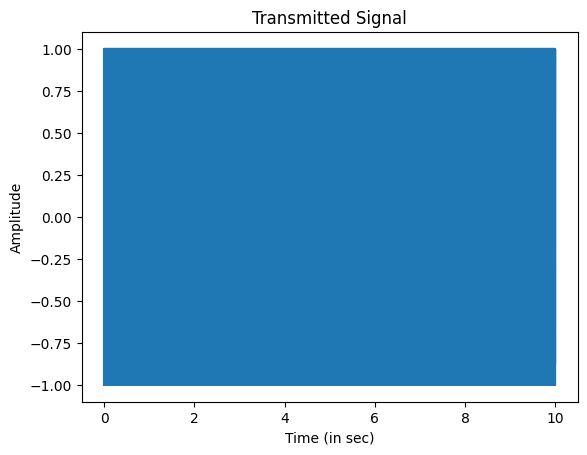

In [7]:
# Time vs Amplitude plot for the transmitted signal
plt.plot([i/sampling_rate for i in range(len(transmitted))], transmitted)
plt.xlabel("Time (in sec)")
plt.ylabel("Amplitude")
plt.title("Transmitted Signal")

In [8]:
F_transmitted, A_transmitted = compute_fft(transmitted, sampling_rate)
all_F_transmitted = [F_transmitted[np.where(A_transmitted == np.sort(A_transmitted)[::-1][i])] for i in range(10)]
print("Transmitted Signal frequencies: ")
all_F_transmitted

Transmitted Signal frequencies: 


[array([18325.58139535]),
 array([19627.90697674]),
 array([18418.60465116]),
 array([18697.6744186]),
 array([19255.81395349]),
 array([19534.88372093]),
 array([19069.76744186]),
 array([18883.72093023]),
 array([19720.93023256]),
 array([18232.55813953])]

Resolution:  0.1000250062515629


Text(0.5, 1.0, 'Transmitted Signal Spectrum')

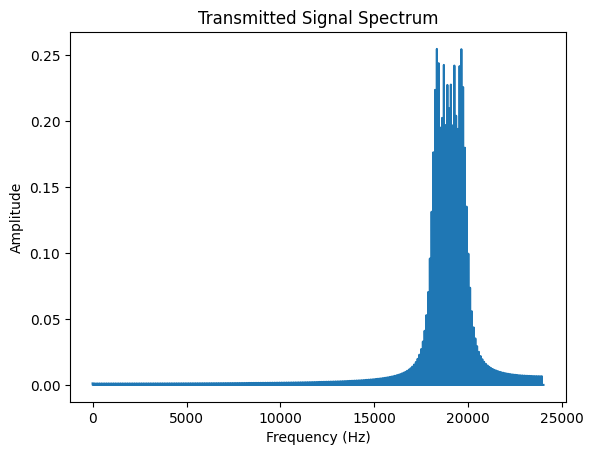

In [9]:
print("Resolution: ", 24000/len(F_transmitted))

plt.plot(F_transmitted, A_transmitted)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.title('Transmitted Signal Spectrum')

In [10]:
def plot_spectogram(signal, sr, n_fft = 128, title = "Spectrogram", hop_length = None, win_length = None, ax = None):
    '''
    Displays a spectrogram (Frequency vs Time) for a signal

    Parameters:
    signal (np.array): the signal
    n_fft (num): length of the windowed signal. 
       Default is 128
    title (str): title of plot. Default is "Spectrogram".
    hop_length (int): number of audio samples between adjacent STFT columns. 
        If hop_length is not given then its value is taken as int(n_fft / 4)
    win_length (int <= n_fft): Each frame of audio is windowed by window of this length 
    ax(matplotlib.axes.Axes): The target axes instance for the plot.

    '''
    if hop_length is None:
        hop_length = int(n_fft / 4)
    
    stft = librosa.stft(y=signal, n_fft = n_fft, hop_length = hop_length, win_length = win_length)
    spectrogram = np.abs(stft)
    spectrogram_db = librosa.amplitude_to_db(spectrogram, ref=np.max)
    
    if hop_length is None:
        hop_length = int(n_fft / 4)  # You can adjust the hop length calculation as needed
    frame_times = librosa.frames_to_time(np.arange(spectrogram.shape[1]), sr=sr, hop_length=hop_length)

    #plt.figure(figsize=(10, 6))
    librosa.display.specshow(spectrogram_db, sr=sr, x_axis='time', y_axis='linear',x_coords=frame_times, ax=ax)
    #print(sr)
    #print(frame_times[len(frame_times)-1])
    
    #plt.ylim(17000,20000)
    
    #plt.colorbar(format='%+2.0f dB')
    plt.xlabel("Time (s)")
    plt.ylabel("Frequency (Hz)")
    plt.title(title)

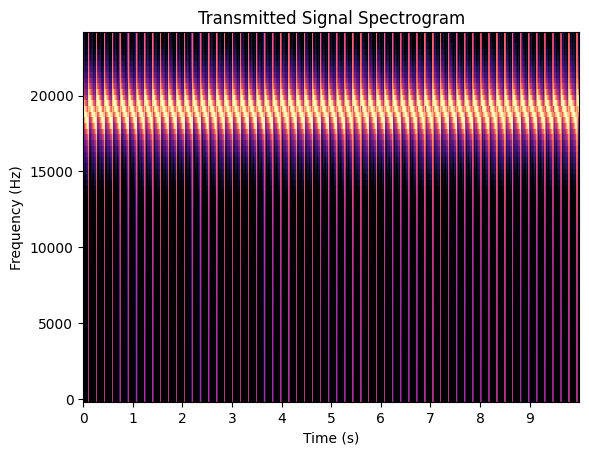

In [11]:
plot_spectogram(transmitted, sampling_rate, title='Transmitted Signal Spectrogram')

##### **Ideal Received Signal (with a delay)**

##### **1. Repeated Received Chirp Signal**
- total signal duration = 15.394s

In [12]:
silence = np.zeros(int(sampling_rate * delay_duration))

In [13]:
delayed_signal = np.concatenate((silence, chirp))
received_chirp = np.tile(delayed_signal, no_of_reps)

Text(0.5, 1.0, 'Received Chirp')

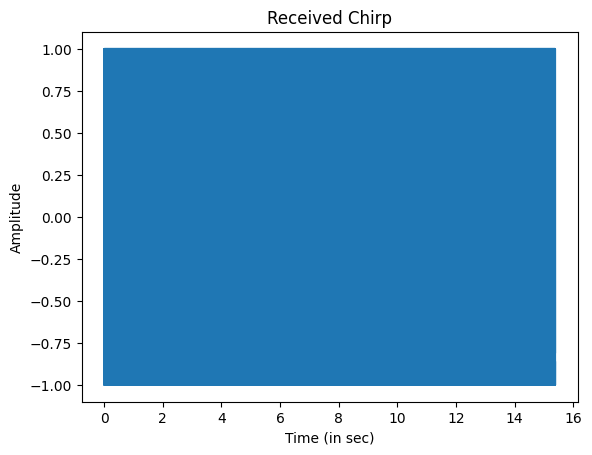

In [14]:
# Time vs Amplitude plot for the transmitted signal
plt.plot([i/sampling_rate for i in range(len(received_chirp))], received_chirp)
plt.xlabel("Time (in sec)")
plt.ylabel("Amplitude")
plt.title("Received Chirp")
#plt.xlim(0,0.1)

Text(0.5, 1.0, 'Received Chirp Spectrum')

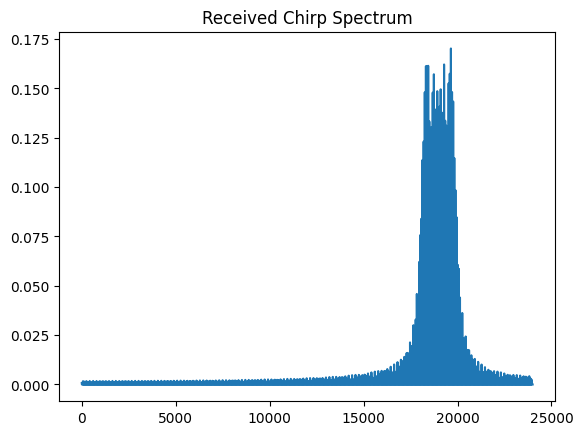

In [15]:
F_rep, A_rep = compute_fft(received_chirp, sampling_rate)
plt.plot(F_rep, A_rep)
plt.title("Received Chirp Spectrum")

##### **2. Repeated Delayed Tone of 11.7Hz**
- total tone duration = 15.394s

In [16]:
def generateAudio(freq, sr, dur, samples=None):
    '''
    Generates a tone (continuous wave)

    Parameters:
    freq (float): frequency of the tone
    sr (num): sampling rate
    dur (num): time duration of tone
    '''
    if samples == None:
        samples = int(sr * dur)
    time = np.linspace(0, dur, samples, False)

    tone = np.sin(2 * np.pi * freq * time)  
    return tone

In [17]:
tone = generateAudio(11.7, sampling_rate, dur)

In [18]:
delayed_tone = np.concatenate((silence, tone))
repeated_tone = np.tile(delayed_tone, no_of_reps)

Text(0.5, 1.0, 'Repeated Delayed Tone')

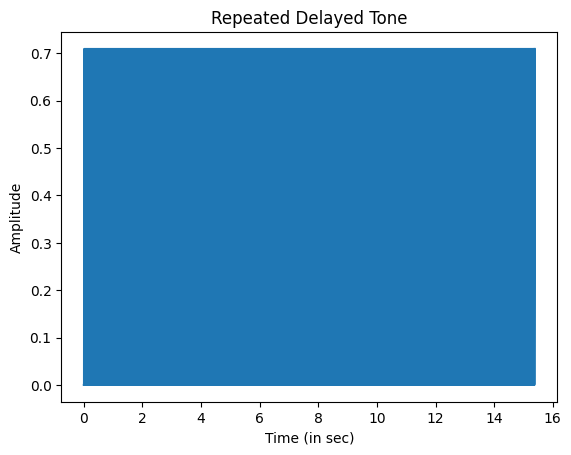

In [19]:
# Time vs Amplitude plot for the transmitted signal
plt.plot([i/sampling_rate for i in range(len(repeated_tone))], repeated_tone)
plt.xlabel("Time (in sec)")
plt.ylabel("Amplitude")
plt.title("Repeated Delayed Tone")

Text(0.5, 1.0, 'Repeated Delayed Tone')

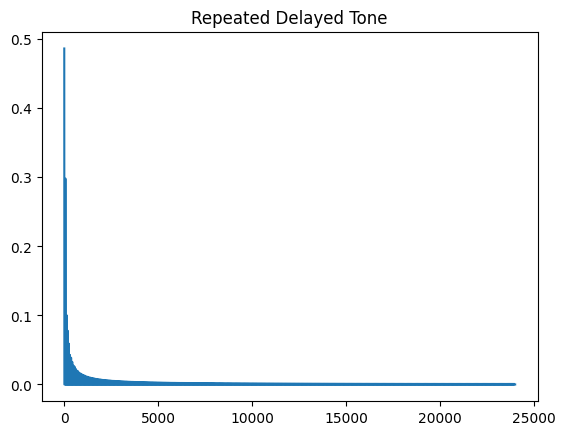

In [20]:
F_rep_tone, A_rep_tone = compute_fft(repeated_tone,sampling_rate)
plt.plot(F_rep_tone,A_rep_tone)
plt.title("Repeated Delayed Tone")

##### **3. Mixed Received Signal (Chirp + Tone)**
- mixing the delayed chirp (18-20kHz) and the delayed tone (11.7Hz)

In [21]:
mixed_signal_received = delayed_signal + delayed_tone

In [22]:
received = np.tile(mixed_signal_received, no_of_reps)

Text(0.5, 1.0, 'Received Mixed Signal (Chirp and 11.7Hz tone)')

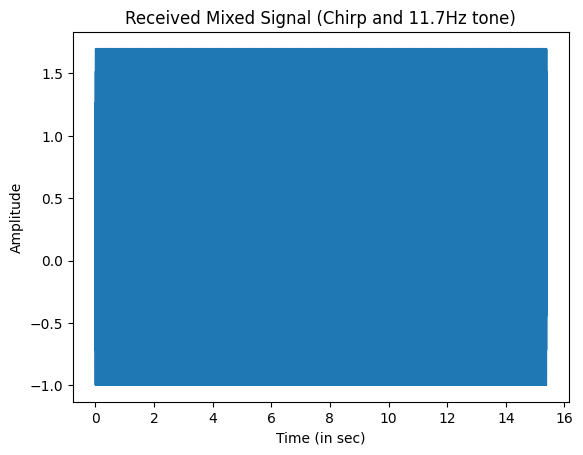

In [23]:
# Time vs Amplitude plot for the Received Mixed Signal
plt.plot([i/sampling_rate for i in range(len(received))], received)
plt.xlabel("Time (in sec)")
plt.ylabel("Amplitude")
plt.title("Received Mixed Signal (Chirp and 11.7Hz tone)")
#plt.xlim(0,0.1)

In [24]:
F_mixed_rep, A_mixed_rep = compute_fft(received, sampling_rate)

all_F_mixed_rep = [F_mixed_rep[np.where(A_mixed_rep == np.sort(A_mixed_rep)[::-1][i])] for i in range(100)]
print("Received Mixed Signal (Chirp and 11.7Hz tone) frequencies: ")
all_F_mixed_rep

Received Mixed Signal (Chirp and 11.7Hz tone) frequencies: 


[array([0.]),
 array([60.4534005]),
 array([19647.35516373]),
 array([18317.38035264]),
 array([18438.28715365]),
 array([19284.63476071]),
 array([18377.83375315]),
 array([19586.90176322]),
 array([18740.55415617]),
 array([19526.44836272]),
 array([18680.10075567]),
 array([19103.27455919]),
 array([18921.91435768]),
 array([19707.80856423]),
 array([18256.92695214]),
 array([19768.26196474]),
 array([19042.82115869]),
 array([18861.46095718]),
 array([19224.1813602]),
 array([18982.36775819]),
 array([19345.08816121]),
 array([18498.74055416]),
 array([19405.54156171]),
 array([18619.64735516]),
 array([18559.19395466]),
 array([19163.7279597]),
 array([18801.00755668]),
 array([19465.99496222]),
 array([18196.47355164]),
 array([19828.71536524]),
 array([18136.02015113]),
 array([120.90680101]),
 array([19889.16876574]),
 array([19949.62216625]),
 array([18075.56675063]),
 array([181.36020151]),
 array([18015.11335013]),
 array([17954.65994962]),
 array([20010.07556675]),
 array([

Resolution:  0.06500365645567563


Text(0.5, 1.0, 'Received Mixed Signal (Chirp and 11.7Hz tone) Spectrum')

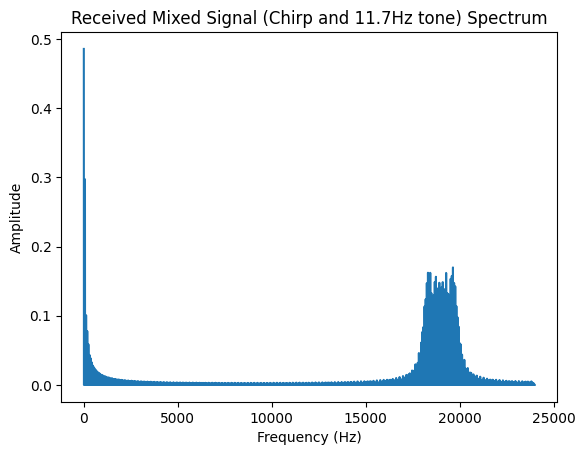

In [25]:
print("Resolution: ", 24000/len(F_mixed_rep))

plt.plot(F_mixed_rep, A_mixed_rep)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.title('Received Mixed Signal (Chirp and 11.7Hz tone) Spectrum')
#plt.xlim(0,100)

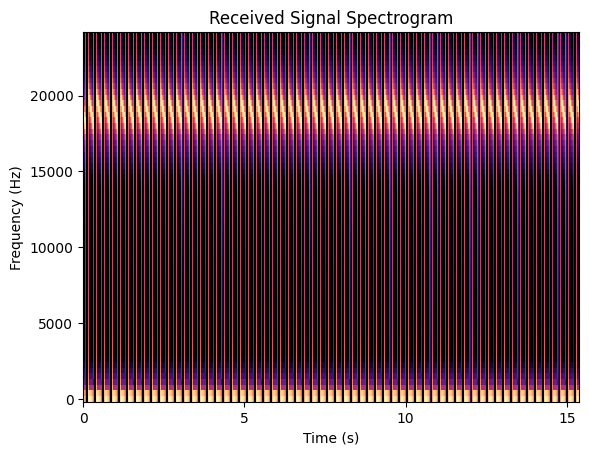

In [26]:
plot_spectogram(received, sampling_rate, title = 'Received Signal Spectrogram')

##### **Mixing of Transmitted and Received (Chirp + Tone) Signal**

In [27]:
if transmitted.shape[0] < received.shape[0]:
    received_signal = received[:transmitted.shape[0]]
else:
    transmitted_signal = transmitted[:received.shape[0]]

mixed_chirp_tone = transmitted * received[:479880]
#mixed_chirp_tone = transmitted * received[:881640]

In [28]:
F,A = compute_fft(mixed_chirp_tone, sampling_rate)

all_F_mixed = [F[np.where(A == np.sort(A)[::-1][i])] for i in range(10)]
print("Mixed Signal frequencies: ")
all_F_mixed

Mixed Signal frequencies: 


[array([18325.58139535]),
 array([19627.90697674]),
 array([18418.60465116]),
 array([18697.6744186]),
 array([19255.81395349]),
 array([19534.88372093]),
 array([19069.76744186]),
 array([18883.72093023]),
 array([19720.93023256]),
 array([18232.55813953])]

Resolution:  0.1000250062515629


Text(0.5, 1.0, 'Mixed Signal Spectrum (Chirp + Tone)')

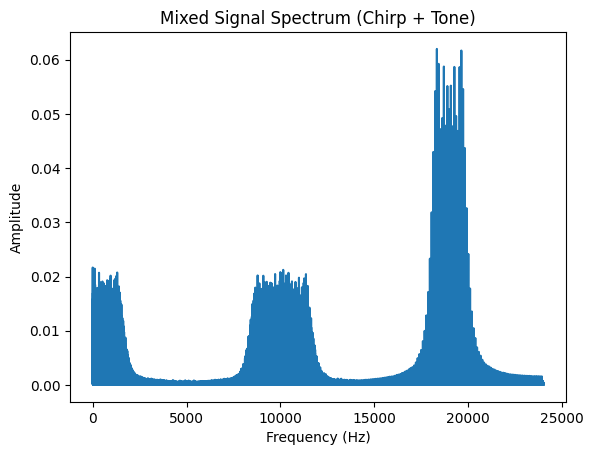

In [29]:
print("Resolution: ", 24000/len(F))
#print("Resolution: ", 44100/len(F))
plt.plot(F, A)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.title('Mixed Signal Spectrum (Chirp + Tone)')
#plt.xlim(0, 5000)

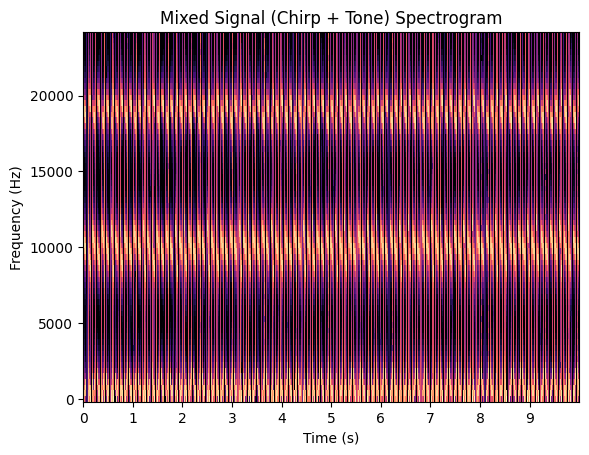

In [30]:
plot_spectogram(mixed_chirp_tone, sampling_rate, title='Mixed Signal (Chirp + Tone) Spectrogram')

In [31]:
def butter_lowpass_filter(data, cutoff, fs, order=5):

    '''
    Applies a lowpass Butterworth filter to the input signal and returns the filtered signal.

    Parameters:
    data (np.array): The signal to be filtered
    cutoff (float): The cutoff frequency for the lowpass filter
    fs (float): The sampling rate of the signal
    order (int): The order of the Butterworth filter. Default is 5
    '''
    
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = lfilter(b, a, data)
    return y

##### **Mixing of Transmitted and Received (Chirp) Signal**

In [32]:
mix = transmitted * received_chirp[:479880]
#mix = transmitted * received_chirp[:881640]
F_mix,A_mix = compute_fft(mix, sampling_rate)

all_F_mix = [F_mix[np.where(A_mix == np.sort(A_mix)[::-1][i])] for i in range(10)]
print("Mixed Signal frequencies: ")
all_F_mix



Mixed Signal frequencies: 


[array([8.20205051]),
 array([112.72818205]),
 array([10147.73693423]),
 array([41.01025256]),
 array([9994.49862466]),
 array([343.28582146]),
 array([1310.52763191]),
 array([10426.80670168]),
 array([10026.80670168]),
 array([9715.42885721])]

Text(0.5, 1.0, 'Mixed Signal (Chirp) Spectrum')

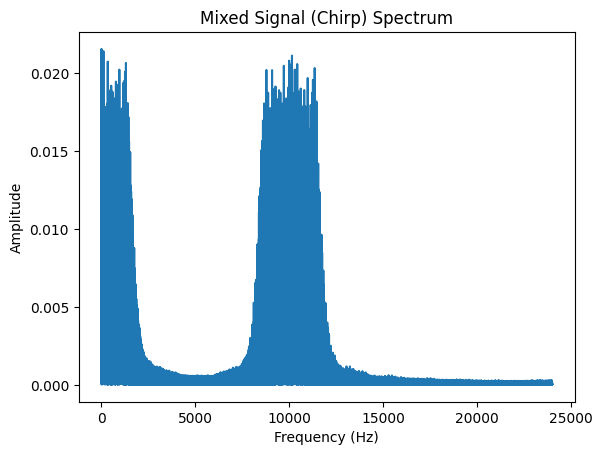

In [33]:
plt.plot(F_mix,A_mix)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.title('Mixed Signal (Chirp) Spectrum')
#plt.xlim(30000,45000)
#plt.xlim(0,3000)

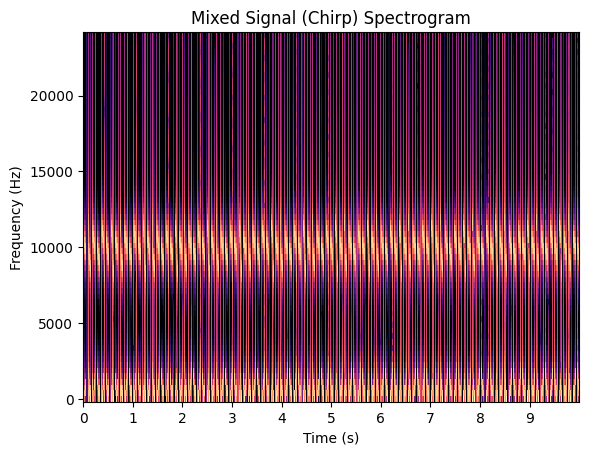

In [34]:
plot_spectogram(mix, sampling_rate, title= 'Mixed Signal (Chirp) Spectrogram')

##### **IF Signal**

In [42]:
slope = 2000/0.01075
cutoff = (slope * delay_duration) # beat frequnecy fb
cutoff = round(cutoff, 4)
print("Cutoff freq: ",cutoff)

Cutoff freq:  1079.0698


In [43]:
if_signal = butter_lowpass_filter(mixed_chirp_tone, cutoff, sampling_rate, order = 4)

Text(0.5, 1.0, 'IF Signal')

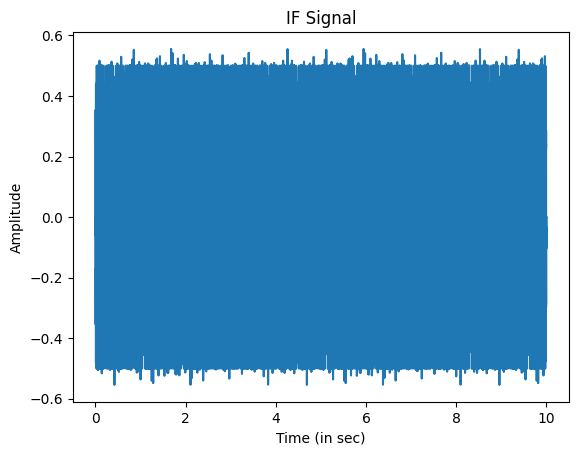

In [44]:
# Time vs Amplitude plot for the transmitted signal
plt.plot([i/sampling_rate for i in range(len(if_signal))], if_signal)
plt.xlabel("Time (in sec)")
plt.ylabel("Amplitude")
plt.title("IF Signal")

In [45]:
F_if, A_if = compute_fft(if_signal, sampling_rate)

all_F_if = [F_if[np.where(A_if == np.sort(A_if)[::-1][i])] for i in range(10)]
print("IF Signal frequencies: ")
all_F_if

IF Signal frequencies: 


[array([8.20205051]),
 array([112.72818205]),
 array([41.01025256]),
 array([343.28582146]),
 array([524.63115779]),
 array([380.29507377]),
 array([586.94673668]),
 array([777.69442361]),
 array([596.34908727]),
 array([134.03350838])]

Resolution:  0.1000250062515629


Text(0.5, 1.0, 'IF Signal Spectrum')

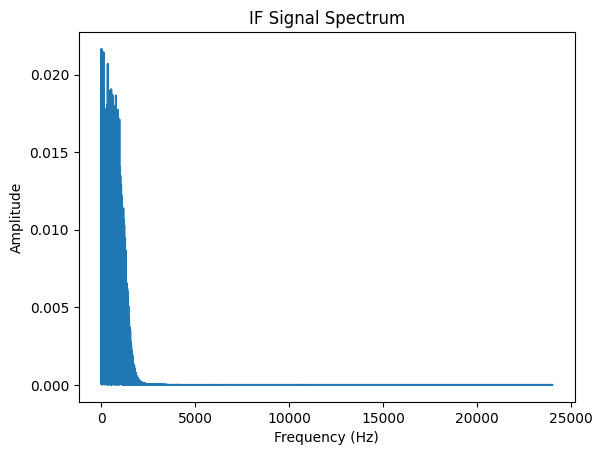

In [47]:
print("Resolution: ", 24000/len(F_if))

plt.plot(F_if, A_if)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.title('IF Signal Spectrum')
#plt.xlim(0,5)